# Clash Royale card balance analysis

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import re
import copy

from tqdm import tqdm

from typing import Union

## Load Raw Data

Read the raw data crawled by scrapy.

In [2]:
with open(os.path.join("cards", "cards.json")) as f:
    raw_cards = json.load(f)

In [3]:
categories = [
    "Troops",
    "Defensive Buildings",
    "Passive Buildings",
    "Damaging Spells",
    "Spawners",
]
NA = "N/A"

In [4]:
category_index = -1
columns = []
cards = {category: [] for category in categories}
ignore = set(
    ["Inferno Dragon", "Mighty Miner", "Goblin Gang", "Ram Rider", "Monk"]
)  # Advanced attacks
extra_details = dict()
for row in raw_cards:
    if "EXTRA" in row:
        row.pop("EXTRA")
        extra_details[row["Card"]] = row
        row.pop("Card")
    elif "columns" in row:
        category_index += 1
        columns = row["columns"]
    else:
        if row["Card"] in ignore:
            continue
        cards[categories[category_index]].append(row)

In [5]:
extra_details["Archers"], cards["Troops"][0]

({'Cost': '3',
  'Hit Speed': '0.9 sec',
  'Speed': 'Medium (60)',
  'Deploy Time': '1 sec',
  'Range': '5',
  'Target': 'Air & Ground',
  'Count': 'x2',
  'Transport': 'Ground'},
 {'Card': 'Archers',
  'Cost': '3',
  'Health (+Shield)': '304',
  'Damage': '107',
  'Hit Speed (seconds)': '1.1',
  'Damage per Second': '97',
  'Spawn/Death Damage': '0',
  'Range': '5',
  'Count': '2'})

## Convert Data

Convert the raw data fields to usable int and float types for the troops.

In [6]:
troops = cards["Troops"]

In [7]:
troops[0]

{'Card': 'Archers',
 'Cost': '3',
 'Health (+Shield)': '304',
 'Damage': '107',
 'Hit Speed (seconds)': '1.1',
 'Damage per Second': '97',
 'Spawn/Death Damage': '0',
 'Range': '5',
 'Count': '2'}

In [8]:
def convert_to_int(val: str) -> Union[str, int]:
    return int(val) if val != NA else val


def convert_to_float(val: str) -> Union[str, float]:
    return float(val) if val != NA else val

In [9]:
health_regex = re.compile("(\d+)\s?(?:\(\+(\d+)\))?")
spawn_death_damage_regex = re.compile("(\d+).*")
range_regex = re.compile("([+-]?[0-9]*[.]?[0-9]+).*")
damage_regex = re.compile("([+-]?[0-9]*[.]?[0-9]+).*")
speed_regex = re.compile("[a-zA-z\s]+ \(([0-9]+)\)")
for troop in troops:
    tmp = troop["Health (+Shield)"].replace(",", "")
    match = health_regex.match(tmp)
    troop["Health (+Shield)"] = sum(
        map(lambda x: int(x) if x is not None else 0, match.groups())
    )
    tmp = troop["Spawn/Death Damage"].replace(",", "")
    match = spawn_death_damage_regex.match(tmp)
    troop["Spawn/Death Damage"] = int(match.groups()[0])

    tmp = troop["Range"]
    match = range_regex.match(tmp)
    troop["Range"] = float(match.groups()[0])

    tmp = troop["Damage"]
    match = damage_regex.match(tmp)
    troop["Damage"] = int(match.groups()[0])

    tmp = troop["Damage per Second"]
    if tmp != NA:
        match = damage_regex.match(tmp)
        troop["Damage per Second"] = float(match.groups()[0])

    troop["Hit Speed (seconds)"] = convert_to_float(troop["Hit Speed (seconds)"])
    troop["Count"] = convert_to_int(troop["Count"])
    troop["Cost"] = convert_to_int(troop["Cost"])

    try:
        speed = extra_details[troop["Card"]]["Speed"]
        troop["Speed"] = int(speed_regex.match(speed).groups()[0]) / 60
    except KeyError:
        troop["Speed"] = NA

In [10]:
def get_df(data_dict: list[dict], keys: list[str]) -> tuple[list[dict], pd.DataFrame]:
    """Get a clean subset of the data with the mentioned keys and return them."""
    chosen = []
    for troop in troops:
        tmp_troop = dict()
        ignore = False
        for key in keys:
            if troop[key] == NA:
                ignore = True
                break
            tmp_troop[key] = troop[key]
        if ignore:
            continue
        chosen.append(tmp_troop)
    return chosen, pd.DataFrame(chosen)

In [11]:
clean_troops, troops_df = get_df(
    troops,
    [
        "Card",
        "Count",
        "Cost",
        "Health (+Shield)",
        "Damage per Second",
        "Hit Speed (seconds)",
        "Speed",
        "Range",
    ],
)

In [12]:
troops_df.head()

,Card,Count,Cost,Health (+Shield),Damage per Second,Hit Speed (seconds),Speed,Range
0,Archers,2,3,304,97.0,1.1,1.0,5.00
1,Archer Queen,1,5,1000,188.0,1.2,1.0,5.00
2,Baby Dragon,1,4,1152,107.0,1.5,1.5,3.50
3,Balloon,1,5,1680,320.0,2.0,1.0,0.10
4,Bandit,1,3,907,193.0,1.0,1.5,0.75


## Troop vs. Troop Battle Simulation

In [13]:
from dataclasses import dataclass


@dataclass
class Troop:
    """Class for keeping track of a troop."""

    name: str
    cost: int
    health: int
    count: int
    damage_per_second: float
    hit_speed: float
    troop_range: float
    count: int
    speed: float
    position: int  # Assume troops are on two ends of an straight line

In [14]:
def convert_to_dataclass(troop_dict: dict) -> Troop:
    return Troop(
        troop_dict["Card"],
        troop_dict["Cost"],
        troop_dict["Health (+Shield)"],
        troop_dict["Count"],
        troop_dict["Damage per Second"],
        troop_dict["Hit Speed (seconds)"],
        troop_dict["Range"],
        troop_dict["Speed"],
        0,
    )

In [20]:
# Simulation loop
results = np.zeros((len(clean_troops), len(clean_troops)))
for current_idx in tqdm(range(len(clean_troops))):
    for next_idx in range(current_idx + 1, len(clean_troops)):
        # current_idx = 57
        # next_idx = 0
        left = convert_to_dataclass(clean_troops[current_idx])
        right = convert_to_dataclass(clean_troops[next_idx])
        right.position = 32
        lefts = []
        rights = []
        for i in range(left.count):
            lefts.append(copy.copy(left))

        for i in range(right.count):
            rights.append(copy.copy(right))

        winner = None
        right_name = right.name
        left_name = left.name
        while winner is None:
            distance = abs(lefts[0].position - rights[0].position)

            # print(distance)
            # print(rights)
            # print(lefts)
            # print("+_+")
            if rights[0].troop_range < distance:
                if rights[0].troop_range + rights[0].speed < distance:
                    # Move towards left
                    for right in rights:
                        right.position -= right.speed
                else:
                    for right in rights:
                        right.position -= distance - right.troop_range + 0.1 # To fix some floating point error
            else:
                # Attack left
                for idx, right in enumerate(rights):
                    if idx < len(lefts):
                        lefts[idx].health -= right.damage_per_second
                    else:
                        lefts[-1].health -= right.damage_per_second
            new_distance = abs(lefts[0].position - rights[0].position)
            if lefts[0].troop_range < new_distance:
                if lefts[0].troop_range + lefts[0].speed < new_distance:
                    # Move towards right
                    for left in lefts:
                        left.position += left.speed
                else:
                    for left in lefts:
                        left.position += new_distance - left.troop_range + 0.1 # To fix some floating point error
            elif lefts[0].troop_range < distance:
                pass
            else:
                # Attack right
                for idx, left in enumerate(lefts):
                    if idx < len(rights):
                        rights[idx].health -= left.damage_per_second
                    else:
                        rights[-1].health -= left.damage_per_second
            lefts = list(filter(lambda tr: tr.health > 0, lefts))
            rights = list(filter(lambda tr: tr.health > 0, rights))
            if len(lefts) == 0 and len(rights) == 0:
                winner = "Draw"
                results[current_idx, next_idx] = 2
                results[next_idx, current_idx] = 2
            elif len(rights) == 0:
                winner = left_name
                results[current_idx, next_idx] = 1
                results[next_idx, current_idx] = 0
            elif len(lefts) == 0:
                winner = right_name
                results[current_idx, next_idx] = 0
                results[next_idx, current_idx] = 1

        # print(f"{left_name} vs {right_name}: {winner}")

100%|███████████████████████████████████████████████| 63/63 [00:00<00:00, 804.19it/s]


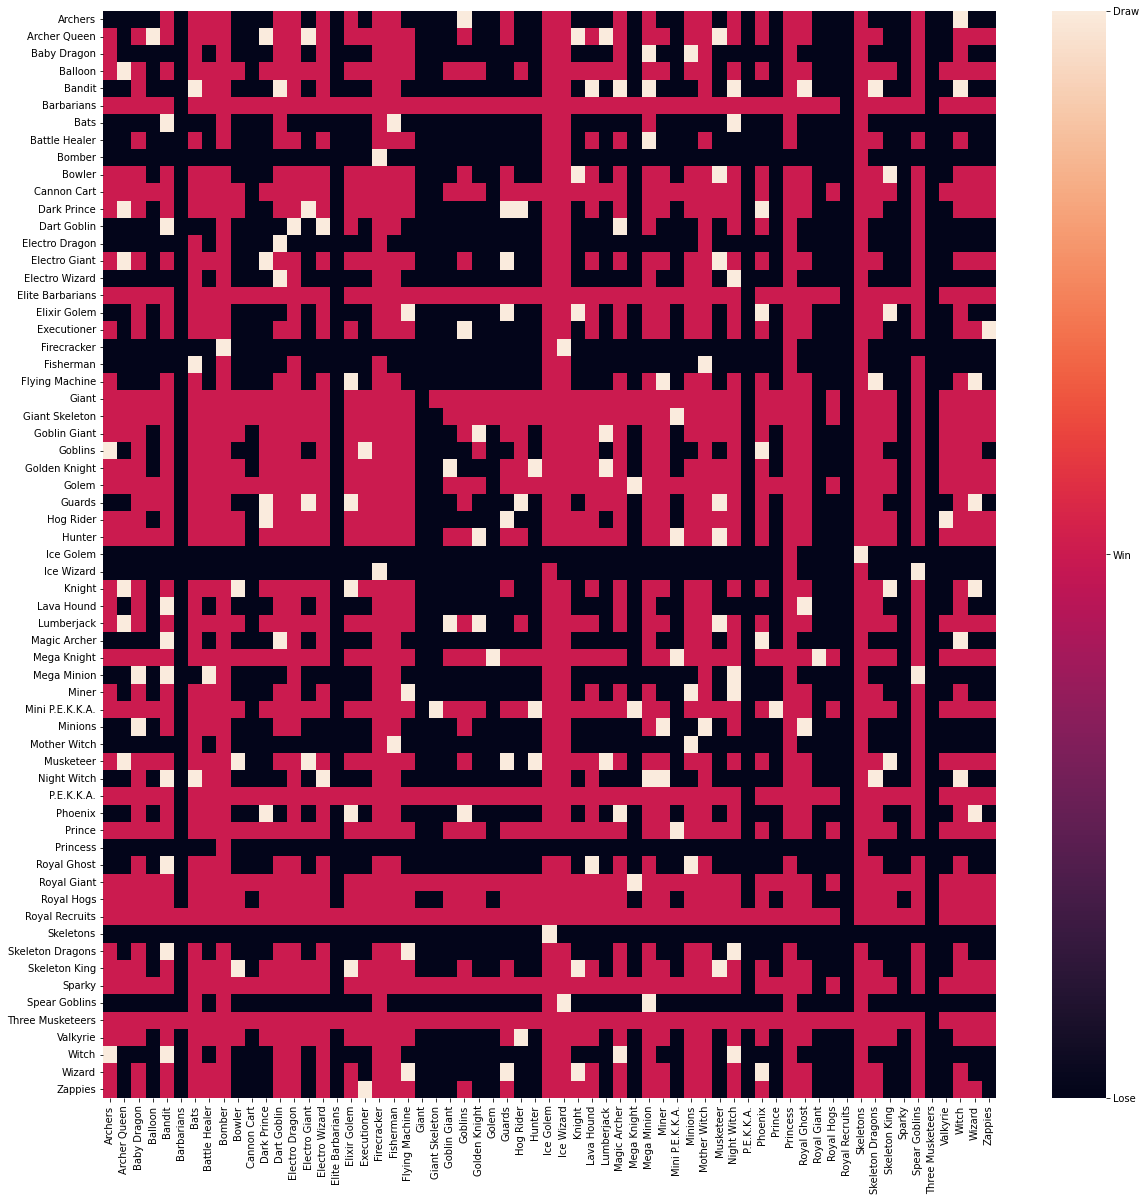

In [21]:
df_cm = pd.DataFrame(
    results,
    index=[troop["Card"] for troop in clean_troops],
    columns=[troop["Card"] for troop in clean_troops],
)
plt.figure(figsize=(20, 20))
ax = sn.heatmap(df_cm)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 1, 2])
colorbar.set_ticklabels(["Lose", "Win", "Draw"])

In [22]:
results[results == 2] = 0
print("Most powerful cards:")
print(
    np.array([troop["Card"] for troop in clean_troops])[
        np.argsort(-np.sum(results, axis=1))
    ]
)

Most powerful cards:
['Three Musketeers' 'Royal Recruits' 'Barbarians' 'P.E.K.K.A.'
 'Elite Barbarians' 'Sparky' 'Royal Giant' 'Giant' 'Giant Skeleton'
 'Golem' 'Mega Knight' 'Cannon Cart' 'Prince' 'Royal Hogs'
 'Mini P.E.K.K.A.' 'Hunter' 'Balloon' 'Goblin Giant' 'Golden Knight'
 'Lumberjack' 'Valkyrie' 'Hog Rider' 'Bowler' 'Skeleton King' 'Musketeer'
 'Archer Queen' 'Zappies' 'Electro Giant' 'Dark Prince' 'Knight' 'Goblins'
 'Guards' 'Executioner' 'Wizard' 'Elixir Golem' 'Phoenix' 'Miner'
 'Archers' 'Flying Machine' 'Lava Hound' 'Battle Healer'
 'Skeleton Dragons' 'Royal Ghost' 'Baby Dragon' 'Minions' 'Witch'
 'Magic Archer' 'Night Witch' 'Bandit' 'Electro Wizard' 'Dart Goblin'
 'Mega Minion' 'Electro Dragon' 'Bats' 'Fisherman' 'Mother Witch'
 'Spear Goblins' 'Firecracker' 'Ice Wizard' 'Bomber' 'Princess'
 'Ice Golem' 'Skeletons']


### Analyzing cost and benefit of cards using scatter plots and correlation

Correlation: 0.669064739963146


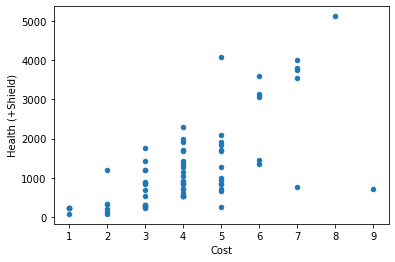

In [23]:
_, subset = get_df(troops, ["Health (+Shield)", "Cost"])
subset.plot.scatter(x="Cost", y="Health (+Shield)")
print("Correlation:", subset["Cost"].corr(subset["Health (+Shield)"]))

Correlation: 0.24382992188036215


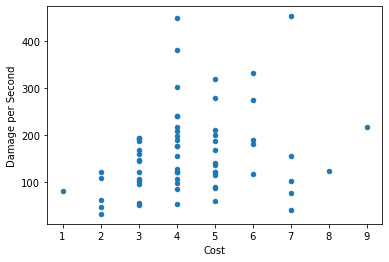

In [24]:
_, subset = get_df(troops, ["Damage per Second", "Cost"])
subset.plot.scatter(x="Cost", y="Damage per Second")
print("Correlation:", subset["Cost"].corr(subset["Damage per Second"]))

Correlation: 0.05054705387132034


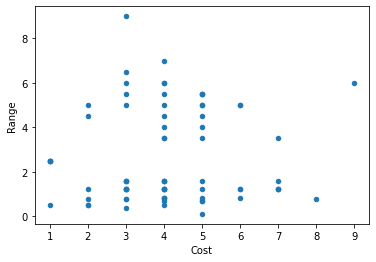

In [25]:
_, subset = get_df(troops, ["Range", "Cost"])
subset.plot.scatter(x="Cost", y="Range")
print("Correlation:", subset["Cost"].corr(subset["Range"]))

In [26]:
troops[0]

{'Card': 'Archers',
 'Cost': 3,
 'Health (+Shield)': 304,
 'Damage': 107,
 'Hit Speed (seconds)': 1.1,
 'Damage per Second': 97.0,
 'Spawn/Death Damage': 0,
 'Range': 5.0,
 'Count': 2,
 'Speed': 1.0}

Correlation: 0.6067387072663101


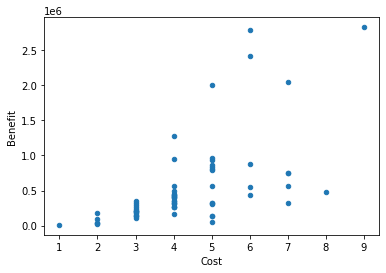

In [27]:
# Example of adding a new column that combines existing ones
_, s = get_df(
    troops,
    [
        "Damage per Second",
        "Health (+Shield)",
        "Cost",
        "Count",
        "Spawn/Death Damage",
        "Range",
    ],
)
s["Benefit"] = (
    s["Count"]
    * (s["Health (+Shield)"] * s["Damage per Second"] + s["Spawn/Death Damage"])
    * s["Range"]
)
s.plot.scatter(x="Cost", y="Benefit")
print("Correlation:", s["Cost"].corr(s["Benefit"]))